In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, fbeta_score, roc_curve

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_pickle('kickstarter_analysis.pkl')
df = df.dropna()

In [84]:
## Selecting Features
features=['country','img_count', 'vid_count',
          'usd_goal', 'description_len', 'blurb_len', 'slug_len', 'med_rewards','category_core']
dependent=['reach_goal']
toscale = ['img_count', 'vid_count', 'usd_goal', 'description_len', 'blurb_len', 'slug_len', 'med_rewards']

In [85]:
X=df[features]
y=df[dependent]

## Getting dummy variables
X = pd.get_dummies(X, drop_first = True)
y = y.values.ravel()

# Logistic Regression

In [86]:
###################
## Initial Model
###################
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.3, random_state = 42)

clf = LogisticRegression(solver = 'liblinear')
clf.fit(X_train, y_train)

training = clf.predict(X_train)
testing = clf.predict(X_test)

train_acc = accuracy_score(y_train, training)
test_acc = accuracy_score(y_test, testing)

print("Training acc_score: {} \nTesting acc_score: {}".format(train_acc, test_acc))

Training acc_score: 0.6959186081796419 
Testing acc_score: 0.6985740977480578


In [87]:
#################
## Utilizing CV
#################
X_arr = X.values
final = 0
clf = LogisticRegression(solver='liblinear')
for train, test in KFold(n_splits=5).split(X_arr):
    clf.fit(X_arr[train], y[train])
    pred = clf.predict(X_arr[test])
    acc = accuracy_score(y[test], pred)
    final += acc
    
final = final / 5 # n of folds
print(final)

0.7005386359428177


In [88]:
###########################
## Utilizing GridSearchCV
###########################
params = {'C':[0.0001, 0.001, 0.1, 1, 10, 100]}
clf = LogisticRegression(solver='liblinear')
gs_cv = GridSearchCV(clf, param_grid=params, cv = 5)
gs_cv.fit(X_train, y_train)

print('The best parameters are: {} \nand the best score is: {}'.format(gs_cv.best_params_, gs_cv.best_score_))

The best parameters are: {'C': 100} 
and the best score is: 0.7011362486934826


In [93]:
################################
## Implementing A Robust Scaler
################################
from sklearn.compose import ColumnTransformer
robust_transformer = Pipeline(steps = [ ('robust', RobustScaler()) ] )
preprocessor = ColumnTransformer(remainder = 'passthrough', 
                                transformers = [('rb', robust_transformer, toscale)])
preprocessor.fit(X)
X_scale = preprocessor.transform(X)

In [119]:
###############################
## Initial Model using Scaled
###############################
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_scale, y, 
                                                   test_size = 0.3, random_state = 42)


clf = LogisticRegression(solver='liblinear')
clf.fit(Xs_train, ys_train)

training = clf.predict(Xs_train)
y_pred = clf.predict(Xs_test)

train_acc = accuracy_score(ys_train, training)
test_acc = accuracy_score(ys_test, y_pred)

print("Training acc_score: {} \nTesting acc_score: {}".format(train_acc, test_acc))

Training acc_score: 0.7270980140935298 
Testing acc_score: 0.7315960271413118


In [106]:
###############################
## Initial Model using Scaled & roc_auc
###############################
training = clf.predict(Xs_train)
y_pred = clf.predict(Xs_test)

ra_train_acc = roc_auc_score(ys_train, training)
ra_test_acc = roc_auc_score(ys_test, y_pred)

print("Training acc_score: {} \nTesting acc_score: {}".format(ra_train_acc, ra_test_acc))

Training acc_score: 0.7117531733271156 
Testing acc_score: 0.7173605953558871


In [117]:
#####################
## ROC Curve
####################
fpr, tpr, thresholds = roc_curve(ys_test, y_pred)
print(fpr)
print(tpr)
print(thresholds)

[0.         0.39974028 1.        ]
[0.         0.83446147 1.        ]
[2 1 0]


(0, 1)

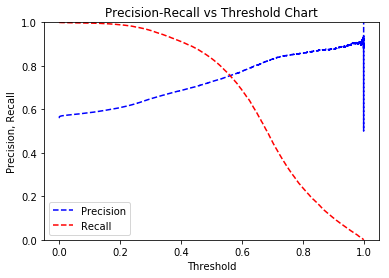

In [124]:
########################
## Using Precision/Recall graphically
########################
## https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn
y_pred = clf.predict(Xs_test)
y_probs = clf.predict_proba(Xs_test)

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(ys_test, y_probs[:,1])

pr_auc = auc(recall, precision)


plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [104]:
###########################
## Utilizing GridSearchCV w/ roc_auc
###########################
r_a = make_scorer(roc_auc_score)

params = {'C':[0.0001, 0.001, 0.1, 1, 10, 100]}
clf = LogisticRegression(solver='liblinear')
gs_cv = GridSearchCV(clf, param_grid=params, scoring = r_a, cv = 5)
gs_cv.fit(Xs_train, ys_train)

print('The best parameters are: {} \nand the best score is: {}'.format(gs_cv.best_params_, gs_cv.best_score_))

The best parameters are: {'C': 0.001} 
and the best score is: 0.7143655989802629


In [110]:
#########################
## Utilizing GSCV w/ fbeta
#########################
f_precision = make_scorer(fbeta_score, beta = .5) ## More weight towards precision

params = {'C':[0.0001, 0.001, 0.1, 1, 10, 100]}
clf = LogisticRegression(solver='liblinear')
gs_cv = GridSearchCV(clf, param_grid=params, scoring = f_precision, cv = 5)
gs_cv.fit(Xs_train, ys_train)

print('The best parameters are: {} \nand the best score is: {}'.format(gs_cv.best_params_, gs_cv.best_score_))

The best parameters are: {'C': 0.001} 
and the best score is: 0.7443336134110379


In [134]:
######################
## LogReg model using optimal C and scored by fbeta
######################

logreg = LogisticRegression(solver='liblinear', C=0.001)
logreg.fit(Xs_train, ys_train)

y_pred = logreg.predict(Xs_test)
y_probs = logreg.predict_proba(Xs_test)

thresh = y_probs[:,1] > .6

score = fbeta_score(y_test, thresh, beta = 0.5)
print(score)

0.7543588011958393


# SVM

In [135]:
from sklearn.svm import LinearSVC

In [136]:
######################
## Initial SVM Model
######################
svc = LinearSVC()
svc.fit(Xs_train, ys_train)
y_pred = svc.predict(Xs_test)

score = fbeta_score(y_test, y_pred, beta = 0.5)
print(score)

0.7413578063627394


/Users/Matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [137]:
######################
## Initial SVM Model, adjusting max_iter
######################
svc = LinearSVC(max_iter = 2000)
svc.fit(Xs_train, ys_train)
y_pred = svc.predict(Xs_test)

score = fbeta_score(y_test, y_pred, beta = 0.5)
print(score)

0.7409795812070217


/Users/Matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [138]:
######################
## Initial SVM Model, adjusting max_iter, 4000
######################
svc = LinearSVC(max_iter = 4000)
svc.fit(Xs_train, ys_train)
y_pred = svc.predict(Xs_test)

score = fbeta_score(y_test, y_pred, beta = 0.5)
print(score)

0.740694812160143


/Users/Matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
